# Extended Data
 Load and Process Extended Simulation Data

In [1]:
import pandas as pd
import numpy as np

# Load the new simulation data
df = pd.read_csv('extended_thermal_data.csv')

# Basic sanity check
print(df.head())
print(df['Profile'].value_counts())  # Confirm all 3 profiles are present

   Thickness       Time  Outer_Temperature Profile
0       0.01   0.000000          20.000000     sin
1       0.01   7.518797          20.007401     sin
2       0.01  15.037594          20.015947     sin
3       0.01  22.556391          20.047089     sin
4       0.01  30.075188          20.099021     sin
Profile
sin     8000
cos     8000
step    8000
Name: count, dtype: int64


Feature Engineering

Add engineered features like Temp_Diff, Fourier Number, and Efficiency:

In [3]:
# Add Temp_Diff assuming inner temp is 20°C
df['Temp_Diff'] = df['Outer_Temperature'] - 20

# Thermal properties (same as MATLAB)
k = 0.5
rho = 900
cp = 2500

# Compute Fourier Number
df['Fourier_Number'] = (k * df['Time']) / (rho * cp * df['Thickness']**2)

# Compute Insulation Efficiency (with small epsilon to avoid div by zero)
epsilon = 1e-6
df['Insulation_Efficiency'] = df['Thickness'] / (df['Temp_Diff'] + epsilon)

# Drop any rows with invalid values (e.g., from numerical noise)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

Normalize and Apply PCA

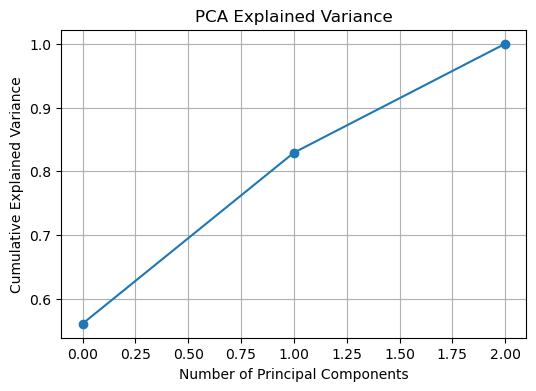

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select relevant features
features = ['Thickness', 'Fourier_Number', 'Temp_Diff']
X = df[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Append PCA results to DataFrame
df_pca = df.copy()
df_pca[['PC1', 'PC2', 'PC3']] = X_pca

 Prepare the Data python Copy Edit

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
import numpy as np

# Select PCA features and target
X_pca = df_pca[['PC1', 'PC2']]
y = df_pca['Insulation_Efficiency']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Train and Evaluate Random Forest

In [7]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate
print("\n📊 Random Forest (PCA)")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_rf):.4f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE: {rmse:.4f}")

print(f"R²:   {r2_score(y_test, y_pred_rf):.4f}")


📊 Random Forest (PCA)
MAE:  4934.7086
RMSE: 16072.2739
R²:   0.8824


🔍 Quick Fix & Diagnostic Steps
 Check the range of our target variable

In [8]:
print(df_pca['Insulation_Efficiency'].describe())

count    2.400000e+04
mean     2.942428e+04
std      4.750349e+04
min     -1.323000e+06
25%      7.717814e-02
50%      2.921854e+00
75%      5.421053e+04
max      2.212509e+05
Name: Insulation_Efficiency, dtype: float64


this clearly shows that our Insulation_Efficiency values are severely skewed due to outliers, and likely calculated incorrectly for some rows.

 Clip or filter based on reasonable efficiency range From your earlier simulations, valid efficiency values were generally between 0.001 and 20.

In [9]:
# Remove rows with unrealistic efficiency values
df_pca_clean = df_pca[(df_pca['Insulation_Efficiency'] > 0) & 
                      (df_pca['Insulation_Efficiency'] < 50)]

Confirm the cleanup worked

In [10]:
print(df_pca_clean['Insulation_Efficiency'].describe())

count    10478.000000
mean         2.763178
std          7.328802
min          0.002615
25%          0.074339
50%          0.226139
75%          1.171238
max         49.982243
Name: Insulation_Efficiency, dtype: float64


Rerun your model with the cleaned data

In [11]:
X_pca = df_pca_clean[['PC1', 'PC2']]
y = df_pca_clean['Insulation_Efficiency']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Refit Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n📊 Random Forest (PCA-cleaned)")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_rf):.4f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2_score(y_test, y_pred_rf):.4f}")


📊 Random Forest (PCA-cleaned)
MAE:  0.1822
RMSE: 1.0362
R²:   0.9808


# Train FCNN on PCA-Cleaned Data

In [12]:
# prepare the inputs
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Use the cleaned PCA data
X_pca = df_pca_clean[['PC1', 'PC2']].values
y = df_pca_clean['Insulation_Efficiency'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [13]:
# Build and Train FCNN Model
# Define FCNN architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

C:\Users\kawri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 49.2636 - mae: 2.6237 - val_loss: 40.1970 - val_mae: 2.8929
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 35.5029 - mae: 2.7496 - val_loss: 33.4283 - val_mae: 2.4913
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25.1415 - mae: 2.1128 - val_loss: 29.5050 - val_mae: 2.1287
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23.7667 - mae: 1.9794 - val_loss: 25.6116 - val_mae: 2.1289
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.8509 - mae: 1.8858 - val_loss: 23.1013 - val_mae: 1.9510
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 20.1183 - mae: 1.7684 - val_loss: 21.2508 - val_mae: 1.8582
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.2011 - mae: 1.8417 - val_loss: 20.2861 - val_mae: 1.5178
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 17.9855 - mae: 1.5473 - val_loss: 19.2775 - val_mae: 1.5080
Epoch 9/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 

Evaluate Performance

In [14]:
# Predict
y_pred_fcnn = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_fcnn)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_fcnn))
r2 = r2_score(y_test, y_pred_fcnn)

print("\n📊 FCNN (PCA-cleaned)")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 FCNN (PCA-cleaned)
MAE:  1.0143
RMSE: 2.8045
R²:   0.8594


Let’s try improving your FCNN performance by:

✅ Adding Dropout (to prevent overfitting)

✅ Using Batch Normalization (to stabilize training)

✅ Slightly modifying the learning rate for better convergence

 Improved FCNN Architecture
🔹 1. Define the Improved Model

In [22]:
from tensorflow.keras import layers, models, optimizers

# Improved FCNN with dropout and batch normalization
model_improved = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)
])


C:\Users\kawri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model with a Custom Learning Rate

In [23]:
# Slightly lower learning rate
optimizer = optimizers.Adam(learning_rate=0.001)

model_improved.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

Train the Model

In [24]:
# Train
history_improved = model_improved.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 44.6532 - mae: 3.2803 - val_loss: 58.9125 - val_mae: 2.9279
Epoch 2/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 23.6778 - mae: 2.3636 - val_loss: 52.0916 - val_mae: 2.6157
Epoch 3/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 17.3036 - mae: 2.0296 - val_loss: 17.2453 - val_mae: 1.2256
Epoch 4/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.0297 - mae: 1.9552 - val_loss: 19.4032 - val_mae: 1.4708
Epoch 5/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.3095 - mae: 1.9317 - val_loss: 18.9417 - val_mae: 1.4388
Epoch 6/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.4292 - mae: 1.8712 - val_loss: 12.5711 - val_mae: 1.0530
Epoch 7/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.2591 - mae: 1.8649 - val_loss: 10.3616 - val_mae: 0.9894
Epoch 8/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 17.7984 - mae: 1.9648 - val_loss: 13.7217 - val_mae: 1.3369
Epoch 9/100
236/236 ━━━━━━━━━━━━

236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.1874 - mae: 1.6206 - val_loss: 8.1468 - val_mae: 0.8589
Epoch 54/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.1528 - mae: 1.5953 - val_loss: 15.2424 - val_mae: 1.1031
Epoch 55/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.0632 - mae: 1.6132 - val_loss: 30.2486 - val_mae: 1.8808
Epoch 56/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.3856 - mae: 1.7301 - val_loss: 11.7468 - val_mae: 0.8707
Epoch 57/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.9728 - mae: 1.6304 - val_loss: 14.9749 - val_mae: 1.1847
Epoch 58/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.5205 - mae: 1.7273 - val_loss: 8.4893 - val_mae: 0.7460
Epoch 59/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.2203 - mae: 1.5148 - val_loss: 16.7741 - val_mae: 1.0899
Epoch 60/100
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.2178 - mae: 1.7261 - val_loss: 15.6546 - val_mae: 1.1436
Epoch 61/100
236/236 ━━━━━━━━━━━━━━━━━━

In [26]:
# evaluating performance
y_pred_improved = model_improved.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_improved)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_improved))
r2 = r2_score(y_test, y_pred_improved)

print("\n📊 Improved FCNN (Dropout + BatchNorm)")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Improved FCNN (Dropout + BatchNorm)
MAE:  0.7920
RMSE: 2.5299
R²:   0.8856


In [27]:
# Recreate original (non-PCA) dataset
X_original = df[['Thickness', 'Fourier_Number', 'Temp_Diff']]
y_original = df['Insulation_Efficiency']

# Clean if needed
df_clean = df[(y_original > 0) & (y_original < 50)]
X_original = df_clean[['Thickness', 'Fourier_Number', 'Temp_Diff']]
y_original = df_clean['Insulation_Efficiency']

# Train-test split
from sklearn.model_selection import train_test_split
X_train_orig, X_test_orig, y_train_before, y_test_before = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

# Train RF
from sklearn.ensemble import RandomForestRegressor
rf_before = RandomForestRegressor(n_estimators=100, random_state=42)
rf_before.fit(X_train_orig, y_train_before)
y_pred_rf_before = rf_before.predict(X_test_orig)


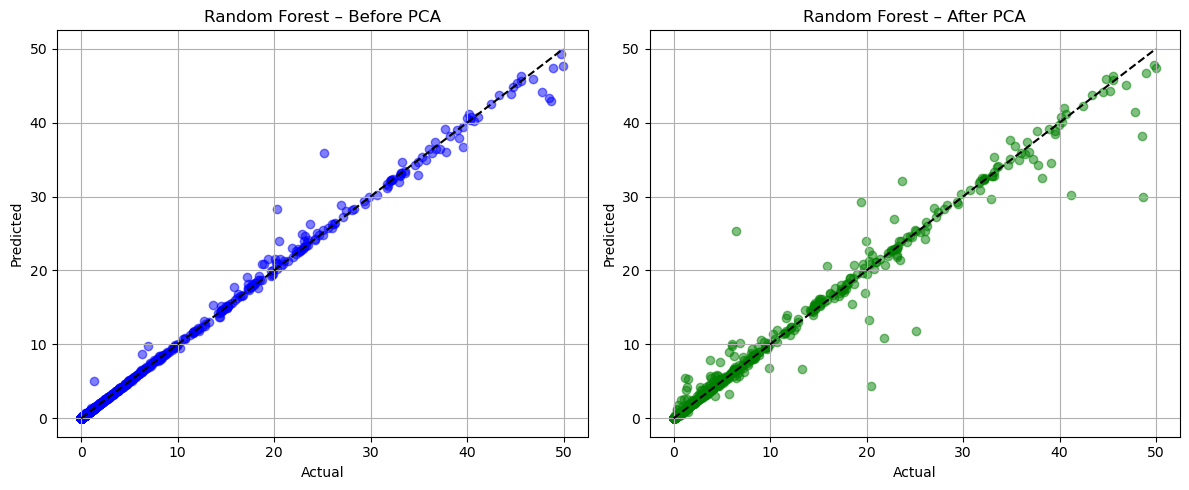

In [29]:
import matplotlib.pyplot as plt

# Assume you have these:
# y_test_before, y_pred_rf_before  (original Random Forest)
# y_test_after,  y_pred_rf_after   (PCA-cleaned Random Forest)

plt.figure(figsize=(12, 5))

# Before PCA
plt.subplot(1, 2, 1)
plt.scatter(y_test_before, y_pred_rf_before, alpha=0.5, color='blue')
plt.plot([y_test_before.min(), y_test_before.max()], [y_test_before.min(), y_test_before.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest – Before PCA")
plt.grid(True)

# After PCA
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest – After PCA")
plt.grid(True)

plt.tight_layout()
plt.show()

 Recreate FCNN with Raw Features (Before PCA)
🔹  Prepare the raw dataset (no PCA)

In [30]:
# Use original cleaned raw feature set
X_raw = df_clean[['Thickness', 'Fourier_Number', 'Temp_Diff']].values
y_raw = df_clean['Insulation_Efficiency'].values

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

In [31]:
# Define and train FCNN

from tensorflow.keras import layers, models

fcnn_raw = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_raw.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

fcnn_raw.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
fcnn_raw.fit(X_train_raw, y_train_raw, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Predict
y_pred_fcnn_raw = fcnn_raw.predict(X_test_raw)

Epoch 1/50


C:\Users\kawri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 48.5738 - mae: 2.6198 - val_loss: 42.3755 - val_mae: 3.4003
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 38.5234 - mae: 3.0032 - val_loss: 34.9552 - val_mae: 2.4050
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 31.5890 - mae: 2.3986 - val_loss: 28.3544 - val_mae: 2.1410
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 25.8221 - mae: 2.0522 - val_loss: 24.0323 - val_mae: 1.8785
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.5548 - mae: 1.8915 - val_loss: 22.4418 - val_mae: 1.6813
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18.3217 - mae: 1.5690 - val_loss: 18.6939 - val_mae: 1.8121
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 17.3585 - mae: 1.6269 - val_loss: 16.4829 - val_mae: 1.4254
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.9027 - mae: 1.4267 - val_loss: 14.8746 - val_mae: 1.6487
Epoch 9/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Visual Comparison Plot

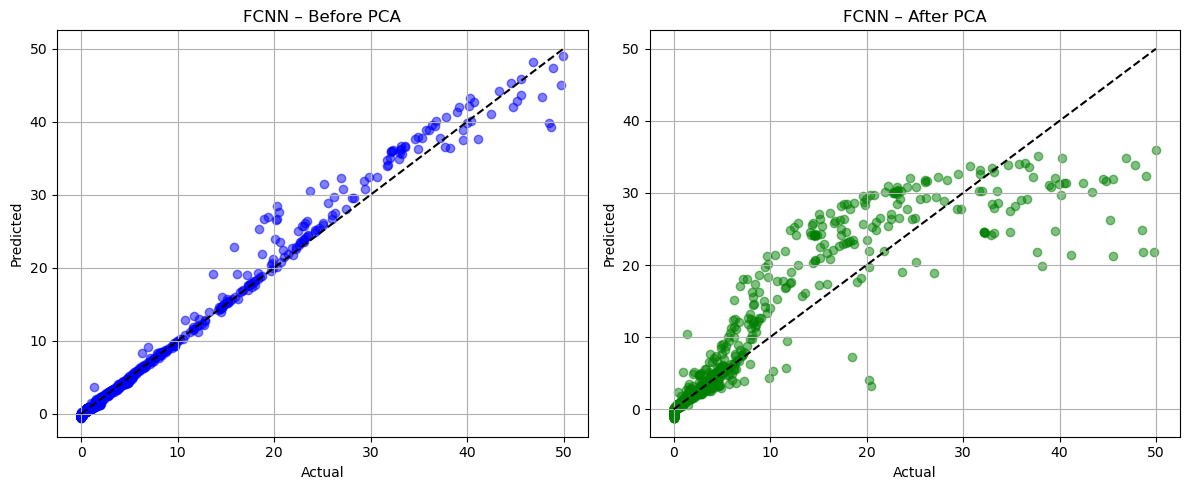

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Before PCA
plt.subplot(1, 2, 1)
plt.scatter(y_test_raw, y_pred_fcnn_raw, alpha=0.5, color='blue')
plt.plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("FCNN – Before PCA")
plt.grid(True)

# After PCA
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_fcnn, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("FCNN – After PCA")
plt.grid(True)

plt.tight_layout()
plt.show()